### Tweet Emotion Detector

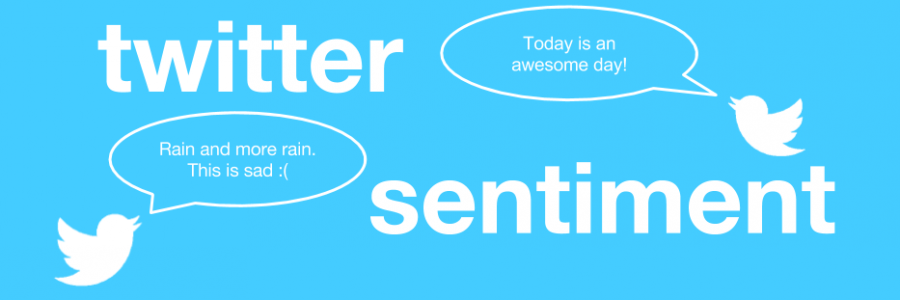

# Tweet Emotion Classifier Using Pre-trained Transformer Embeddings

## Project Overview
Developed a classifier to detect emotions in tweets using pre-trained embeddings from **`sentence-transformers/all-MiniLM-L6-v2`**. The project involved generating embeddings for tweets, building a custom neural network with PyTorch for classification, and training it to identify emotions like "joy," "sadness," and "anger." 

### Key Tools:
- **Hugging Face Transformers**: For embedding generation.
- **PyTorch**: For model building and training.

The model was evaluated on its ability to classify emotions accurately based on the embeddings.

## Use Case
The **Tweet Emotion Classifier** is useful for:
- **Sentiment Analysis**: Understanding overall sentiment in tweets.
- **Social Media Monitoring**: Tracking user emotions and reactions in real time.
- **Customer Feedback Analysis**: Gauging customer emotions in feedback and reviews.

By leveraging pre-trained embeddings, the model efficiently captures the semantic meaning of tweets, enabling accurate emotion classification.




In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import LabelEncoder
import pandas as pd

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/home/adityaa/anaconda3/envs/ml/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
test_db = pd.read_csv('test.csv')
train_db = pd.read_csv('train.csv')
validation_db = pd.read_csv('validation.csv')

label_mapping = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'shocked': 5
}

In [22]:
def tokenize_tweets(tweets):
    return tokenizer(tweets, padding=True, truncation=True, return_tensors="pt")

def get_embeddings(tokenized_tweets):
    with torch.no_grad():
        outputs = model(**tokenized_tweets)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [24]:
train_text_list = list(train_db['text'][:200])
test_text_list = list(test_db['text'][:200])
y_train = train_db['label'][:200]
y_test = test_db['label'][:200]

In [7]:
tokens = tokenize_tweets(train_text_list)
embeddings = get_embeddings(tokens)

In [25]:
sentence = ['my name is Rahul Jain', 'and my age is 40']
example_token = tokenize_tweets(sentence)
embedding = get_embeddings(example_token)
embedding.size()

torch.Size([2, 384])

In [27]:
from torch import nn

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_labels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [28]:
def calculate_accuracy(logits, labels):
    _, predicted_classes = torch.max(logits, 1)
    correct_predictions = torch.eq(predicted_classes, labels).float()
    accuracy = correct_predictions.sum() / len(labels)
    return accuracy.item()


In [29]:
num_labels = len(label_mapping)
y_train.max()

5

In [30]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

train_dataset = TensorDataset(embeddings, torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

input_dim = embedding.size(1)
classifier = EmotionClassifier(input_dim, num_labels)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

for epoch in range(20):
    total_accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        y_logits = classifier(inputs)
        accuracy = calculate_accuracy(y_logits, labels)
        total_accuracy += accuracy
        loss = loss_fn(y_logits, labels)
        loss.backward()
        optimizer.step()
    average_accuracy = total_accuracy / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {average_accuracy}')

Epoch 1, Loss: 1.2487982511520386, Accuracy: 0.3894230769230769
Epoch 2, Loss: 1.7229342460632324, Accuracy: 0.375
Epoch 3, Loss: 1.705031156539917, Accuracy: 0.375
Epoch 4, Loss: 1.5372756719589233, Accuracy: 0.375
Epoch 5, Loss: 0.9743308424949646, Accuracy: 0.5096153846153846
Epoch 6, Loss: 0.9421592354774475, Accuracy: 0.5480769230769231
Epoch 7, Loss: 0.5917611122131348, Accuracy: 0.6153846153846154
Epoch 8, Loss: 0.7586778402328491, Accuracy: 0.7115384615384616
Epoch 9, Loss: 0.16085633635520935, Accuracy: 0.8461538461538461
Epoch 10, Loss: 0.2114715427160263, Accuracy: 0.8846153846153846
Epoch 11, Loss: 0.20884738862514496, Accuracy: 0.8894230769230769
Epoch 12, Loss: 0.2137838751077652, Accuracy: 0.9278846153846154
Epoch 13, Loss: 0.019908644258975983, Accuracy: 0.9567307692307693
Epoch 14, Loss: 0.19836048781871796, Accuracy: 0.9663461538461539
Epoch 15, Loss: 0.010265294462442398, Accuracy: 1.0
Epoch 16, Loss: 0.006321481429040432, Accuracy: 1.0
Epoch 17, Loss: 0.002172144828

In [31]:
def predict(tweet):
    token = tokenize_tweets(tweet)
    embeddings = get_embeddings(token)
    logits = classifier(embeddings)
    _, predicted_class = torch.max(logits, 1)
    for key,val in label_mapping.items():
        if val==predicted_class.item():
            print("the predicted class is: ",key)

In [32]:
predict(['I AM SAD'])

the predicted class is:  sadness
